* Imports

In [256]:
# import
import json
import requests
import pandas as pd
import io
import scipy.stats as stats# from natsort
import numpy as np
import matplotlib.pyplot as plt
import configparser
import boto3
import s3fs 
import psycopg2

from psycopg2 import OperationalError, errorcodes, errors
from matplotlib.ticker import FuncFormatter
from random import randrange
from sodapy import Socrata
from datetime import datetime
from matplotlib.ticker import NullFormatter, FixedLocator
from helpers import github_helper, build_df, inverse, forward, write_dataframe_to_parquet_on_s3, run_query, copy_to_rs, check_s3_write
from sql import *

In [3]:
try:
    config = configparser.ConfigParser()
    config.read('config.cfg')
    cfg = True
except configparser.Error as e:
    print(f"Error reading dwh.cfg: {e}")
    cfg = False

if cfg:
    # aws
    AWS_ACCESS_KEY_ID =  config.get('AWS', 'AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = config.get('AWS', 'AWS_SECRET_ACCESS_KEY')
    TARGET_S3_BUCKET = config.get('S3','STAGING_DATA')
    IS_DEBUG = config.get('ETL','IS_DEBUG')
    IAM = config.get('IAM_ROLE', 'ARN2')
    # urls for data
    nyt_covid = config.get('URL', 'NYT_COVID')
    nyt_county_mask_url = config.get('URL', 'NYT_COUNTY_MASK')
    nyt_covid_counties_url = config.get('URL', 'NYT_COVID_COUNTY')
    # census
    state_population_url = config.get('URL', 'STATE_POPULATION')
    county_pop_url = config.get('URL', 'COUNTY_POPULATION')
    # TSA
    url = config.get('URL', 'TSA')
else:
    print("error reading the config file. Please investigate.")

print('set env')
# Set environ variables
os.environ['AWS_ACCESS_KEY_ID']= AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY']= AWS_SECRET_ACCESS_KEY

set env


* Setup cur to write to Redshift

In [6]:
# connect to redshift
conn = False
cur = False
try:
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    # conn.commit = True
except Exception as e:
    print("Error connecting to Redshift: {}".format(e))
cur = conn.cursor()

if not cur.closed:
    print("cur is open, continue")
else:
    print("cur is closed, please run to re-open")

cur is open, continue


* Create Tables

In [7]:
# state population table
run_query(cur, conn, [states_table_create], 'create state population table')

Starting  
CREATE TABLE IF NOT EXISTS udacity_final.states (
    state_fips VARCHAR(4) NOT NULL PRIMARY KEY,
    state VARCHAR(40) NOT NULL,
    population BIGINT NOT NULL
    )
    diststyle all;

Commit completed


In [8]:
run_query(cur, conn, [county_table_create], 'create county population table')

Starting  
CREATE TABLE IF NOT EXISTS udacity_final.counties (
    county_fips VARCHAR(6) NOT NULL PRIMARY KEY,
    county VARCHAR(60) NOT NULL,
    state_fips VARCHAR(4) NOT NULL,
    population BIGINT NOT NULL
    )
    diststyle all;

Commit completed


In [9]:
run_query(cur, conn, [state_covid_table_create], 'create state covid table')

Starting  
CREATE TABLE IF NOT EXISTS udacity_final.state_covid (
    date Date NOT NULL,
    fips VARCHAR(3) NOT NULL,
    cases BIGINT NOT NULL,
    deaths BIGINT NOT NULL,
    cases_to_death DOUBLE PRECISION NOT NULL
    )
    diststyle all;

Commit completed


In [10]:
run_query(cur, conn, [time_table_create], 'create time table')

Starting 
CREATE TABLE IF NOT EXISTS udacity_final.time (
date DATE NOT NULL PRIMARY KEY,
day DECIMAL NOT NULL, 
week DECIMAL NOT NULL, 
month DECIMAL NOT NULL, 
year DECIMAL NOT NULL, 
weekday DECIMAL NOT NULL
)
diststyle all;

Commit completed


In [11]:
run_query(cur, conn, [state_covid_table_create], 'create state covid table')

Starting  
CREATE TABLE IF NOT EXISTS udacity_final.state_covid (
    date Date NOT NULL,
    fips VARCHAR(3) NOT NULL,
    cases BIGINT NOT NULL,
    deaths BIGINT NOT NULL,
    cases_to_death DOUBLE PRECISION NOT NULL
    )
    diststyle all;

Commit completed


In [12]:
run_query(cur, conn, [county_covid_table_create], 'create county covid table')

Starting  
CREATE TABLE IF NOT EXISTS udacity_final.county_covid (
    date Date NOT NULL,
    fips VARCHAR(5) NOT NULL,
    cases BIGINT NOT NULL,
    deaths BIGINT NOT NULL,
    cases_to_death DOUBLE PRECISION NOT NULL
    )
    diststyle all;

Commit completed


In [91]:
run_query(cur, conn, ['rollback;'], 'create time table')

Starting rollback;
Commit completed


Build State Fact Table

In [13]:
# state population df
state_pop_df = build_df(state_population_url, content_type='json')
state_build = False
if not state_pop_df.empty:
  state_build = True
  print(f"State Population DF created.")
else:
    print(f"State Population DF failed to create.")

State Population DF created.


In [18]:
# Update the data by removing the top row, re-ordering columns, sorting, and setting the data types
if state_build:
  print(state_pop_df.head(1)[0][0].lower())
  # drop header row
  if state_pop_df[0][0].lower() == "name":
      state_pop_df.drop(state_pop_df.head(1).index, inplace = True)
  # set columns, sort, update index, re-order columns, and update types
  state_pop_df.columns = ['name', 'population', 'state_fips']
  state_pop_df.sort_values(by=['state_fips'], ascending=True, inplace=True)
  state_pop_df.reset_index(drop=True, inplace=True)
  state_pop_df = state_pop_df[['state_fips', 'name','population']]
  state_pop_df = state_pop_df.astype({
      'name': 'str',
      'population': 'int',
      'state_fips': 'str'
      })

print(state_pop_df.columns)
print(state_pop_df.dtypes)


name
Index(['state_fips', 'name', 'population'], dtype='object')
state_fips    object
name          object
population     int64
dtype: object


* Create S3 File system object

In [19]:
# create s3fs system
try:
    s3 = s3fs.core.S3FileSystem(key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)
    s3.ls(path=TARGET_S3_BUCKET, details=True)
except Exception as e: 
    print("exception creating s3fs object.")
    s3 = False

* Write state pop to s3

In [28]:
# write state pop df to s3
state_bucket = 'state_data/state_pop'
state_pop_file = 'states'
write_dataframe_to_parquet_on_s3(state_pop_df, TARGET_S3_BUCKET,  state_bucket, state_pop_file)

state_pop_in_s3 = False
state_pop_fmt = 'parquet'

if check_s3_write(s3, TARGET_S3_BUCKET,  state_bucket, state_pop_file, state_pop_fmt):
    print(f"s3 file written")
    state_pop_in_s3 = True
else:
    print(f"s3 file write error")


Writing 52 records to states
tmp [{'Key': 'de-final-project/staging/state_data/state_pop/states.parquet', 'LastModified': datetime.datetime(2021, 1, 21, 0, 25, 35, tzinfo=tzutc()), 'ETag': '"b3a295216345fef4c50a5dee31b0c89d"', 'Size': 3946, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 3946, 'name': 'de-final-project/staging/state_data/state_pop/states.parquet'}]
s3 file name match
s3 file written


In [407]:
# testt s3fs ls()
s3.ls("s3://de-final-project/staging/state_data/states.parquet",details=True)[0]
tmp = s3.ls(path=s3_path, detail=True, refresh=False)

* Write state population to RS

In [40]:
# write state pop parquet to RS
target = f"{SCHEMA}.states".replace("'","")
from_path = TARGET_S3_BUCKET + '/' + state_bucket
copy_cmd = copy_to_rs(target, from_path, 'parquet', IAM)
print(copy_cmd)

if state_pop_in_s3:
    run_query(cur, conn, [copy_cmd], "copy states to RS")
else:
    print(f"state population file not written to s3, please verify.")


    COPY udacity_final.states FROM 's3://de-final-project/staging/state_data/state_pop'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Starting 
    COPY udacity_final.states FROM 's3://de-final-project/staging/state_data/state_pop'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Commit completed


* Data quality check

In [112]:
result = dq_query(cur, target)

process_dq_results(result, target)

There are 104 rows in udacity_final.states. Looks good.


Build County Fact Table

* Create DF

In [98]:
county_pop_df = build_df(county_pop_url, content_type='json')
county_build = False
if not county_pop_df.empty:
    print('County population DF created!')
    county_build = True
else:
    print('County population DF failed to create')

County population DF created!


In [99]:
# drop the header row from the file; set column names and cleanup data
if county_build:
    print(county_pop_df.head(1)[0][0].lower())# drop header row
    if county_pop_df[0][0].lower() == "name":
        county_pop_df.drop(county_pop_df.head(1).index, inplace = True)
    county_pop_df.columns = ['NAME', 'population', 'state_fips', 'fips']
    county_pop_df['county'] = county_pop_df['NAME'].str.split(r'\s*( County)\W*').str[0]  
    county_pop_df.drop('NAME', axis = 1, inplace = True)
    # reorder
    county_pop_df.sort_values(by=['state_fips', 'fips'], ascending=[True, True], inplace=True)
    county_pop_df.reset_index(drop=True, inplace=True)
    county_pop_df = county_pop_df[['fips', 'county', 'state_fips', 'population']]
    # update the types to int64 and str
    county_pop_df = county_pop_df.astype({
    'population': 'int64',
    'state_fips': 'str',
    'county': 'str',
    'fips': 'str'
    })

name


* Write to RS

In [105]:
county_bucket = 'county_data/county_pop'
county_file = 'counties'
county_fmt = 'parquet'

write_dataframe_to_parquet_on_s3(county_pop_df, TARGET_S3_BUCKET, county_bucket ,county_file)
county_pop_in_s3 = False

if check_s3_write(s3, TARGET_S3_BUCKET, county_bucket ,county_file, 'parquet'):
    print(f"s3 file written")
    county_pop_in_s3 = True
else:
    print(f"s3 file write error")

Writing 3220 records to counties
tmp [{'Key': 'de-final-project/staging/county_data/county_pop/counties.parquet', 'LastModified': datetime.datetime(2021, 1, 21, 0, 49, 43, tzinfo=tzutc()), 'ETag': '"f2efd10e2b1eff84d906a9cfbfdd45e3"', 'Size': 47461, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 47461, 'name': 'de-final-project/staging/county_data/county_pop/counties.parquet'}]
s3 file name match
s3 file written


In [106]:
if county_pop_in_s3:
    pass
else:
    print(f"cannot COPY {county_file} to Redshift, the files cannot be found on s3. Please verify")

county_target = f"{SCHEMA}.counties".replace("'","")

county_from_path = TARGET_S3_BUCKET + '/' + county_bucket
county_copy_cmd = copy_to_rs(county_target, county_from_path, 'parquet', IAM)
print(copy_cmd)
if county_pop_in_s3:

    run_query(cur, conn, [county_copy_cmd], "copy states to RS")
else:
    print(f"state population file not written to s3, please verify.")



    COPY udacity_final.states FROM 's3://de-final-project/staging/state_data/state_pop'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Starting 
    COPY udacity_final.counties FROM 's3://de-final-project/staging/county_data/county_pop'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Commit completed


* County pop data check

In [113]:
result = dq_query(cur, county_target)

process_dq_results(result, county_target)

There are 3220 rows in udacity_final.counties. Looks good.


State Level Covid Data

* Create state covid data frame

In [114]:
# create NYT Covid data frame
nyt_covid_request_df = github_helper(nyt_covid, 'csv')
if nyt_covid_request_df.empty:
  print(f"Covid data request failed to create a data frame, please try again.")

In [115]:
# set date to datetime format; add cases to death ratio
nyt_covid_request_df['date'] = pd.to_datetime(nyt_covid_request_df['date'], format = '%Y-%m-%d')
nyt_covid_request_df['case_to_death'] = nyt_covid_request_df['deaths'] / nyt_covid_request_df['cases']
nyt_covid_request_df['fips'] = nyt_covid_request_df['fips'].astype(str).str.pad(width=2, side='left', fillchar='0')

In [116]:
# drop state name, to use fips as FK, re-order table by date and FIPS
nyt_covid_request_df.drop('state', axis = 1, inplace = True)
nyt_covid_request_df.sort_values(by=['date', 'fips'], ascending=[True, True], inplace=True)
nyt_covid_request_df.reset_index(drop=True, inplace=True)

Write to S3

In [117]:
nyt_state_bucket = 'state_data/state_covid'
nyt_state_file = 'state_covid'
state_covid_in_s3 = False
write_dataframe_to_parquet_on_s3( nyt_covid_request_df, TARGET_S3_BUCKET, nyt_state_bucket ,nyt_state_file)

Writing 17779 records to state_covid


* Write to state covid data to RS

In [120]:
if check_s3_write(s3, TARGET_S3_BUCKET,  nyt_state_bucket, nyt_state_file, 'parquet'):
    state_covid_target = f"{SCHEMA}.state_covid".replace("'","")

    state_covid_from_path = TARGET_S3_BUCKET + '/' + nyt_state_bucket
    state_covid_copy_cmd = copy_to_rs(state_covid_target, state_covid_from_path, 'parquet', IAM)
    print(state_covid_copy_cmd)
    run_query(cur, conn, [state_covid_copy_cmd], "copy states to RS")
else:
    print(f"cannot COPY {nyt_state_file} to Redshift, the files cannot be found on s3. Please verify")
    print(f"state population file not written to s3, please verify.")



tmp [{'Key': 'de-final-project/staging/state_data/state_covid/state_covid.parquet', 'LastModified': datetime.datetime(2021, 1, 21, 0, 55, 49, tzinfo=tzutc()), 'ETag': '"40f737d55493797cbde7d16c516c0c5a"', 'Size': 316876, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 316876, 'name': 'de-final-project/staging/state_data/state_covid/state_covid.parquet'}]
s3 file name match

    COPY udacity_final.state_covid FROM 's3://de-final-project/staging/state_data/state_covid'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Starting 
    COPY udacity_final.state_covid FROM 's3://de-final-project/staging/state_data/state_covid'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Commit completed


* Data Quality Check

In [142]:
result = dq_query(cur, state_covid_target)

process_dq_results(result, state_covid_target)

There are 17779 rows in udacity_final.state_covid. Looks good.


* Date Fact Table Creation

In [146]:
date_df = pd.DataFrame()
date_df['date'] = pd.to_datetime(pd.unique(nyt_covid_request_df['date']),format = '%Y-%m-%d')
date_df['day'] = pd.DatetimeIndex(date_df['date']).day
date_df['week'] = pd.DatetimeIndex(date_df['date']).week
date_df['year'] = pd.DatetimeIndex(date_df['date']).year
date_df['month'] = pd.DatetimeIndex(date_df['date']).month
date_df['weekday'] = pd.DatetimeIndex(date_df['date']).weekday


* Write to Date Fact Table to S3

In [151]:
date_bucket = 'date'
date_file = 'dates'
write_dataframe_to_parquet_on_s3( date_df, TARGET_S3_BUCKET, date_bucket ,date_file)

Writing 365 records to dates


* Write date file to Redshift

In [154]:
if check_s3_write(s3, TARGET_S3_BUCKET, date_bucket ,date_file, 'parquet'):
    date_target = f"{SCHEMA}.time".replace("'","")
    date_target_from_path = TARGET_S3_BUCKET + '/' + date_bucket
    date_target_copy_cmd = copy_to_rs(date_target, date_target_from_path, 'parquet', IAM)
    run_query(cur, conn, [date_target_copy_cmd], "copy states to RS")
else:
    print(f"cannot COPY {date_file} to Redshift, the files cannot be found on s3. Please verify")


tmp [{'Key': 'de-final-project/staging/date/dates.parquet', 'LastModified': datetime.datetime(2021, 1, 21, 0, 57, 7, tzinfo=tzutc()), 'ETag': '"2c0d54b6207f2d8d5b7957ed9505d9d6"', 'Size': 7536, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 7536, 'name': 'de-final-project/staging/date/dates.parquet'}]
s3 file name match
Starting 
    COPY udacity_final.time FROM 's3://de-final-project/staging/date'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Commit completed


* Time data check

In [155]:
result = dq_query(cur, date_target)

process_dq_results(result, date_target)

There are 365 rows in udacity_final.time. Looks good.


County Level Covid Data

In [156]:
# createt nyt covid county df
nyt_covid_county_df = github_helper(nyt_covid_counties_url, 'csv')
if not nyt_covid_county_df.empty:
      print(f"County DataFrame created")
else:
    print(f"County DataFrame failed to create.")
print(f"len: {len(nyt_covid_county_df.index)} \ncolumns: {nyt_covid_county_df.columns}")

County DataFrame created
len: 946480 
columns: Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


In [300]:
# # can be removed
# nyt_covid_county_df['fips_len'] = nyt_covid_county_df.fips.astype(str).apply(len)
# nyt_covid_county_df.fips = nyt_covid_county_df.fips.astype(str).str.split('.', expand = True)[0]
# nyt_covid_county_df = nyt_covid_county_df.assign(fips = lambda x: x['fips'].astype(str).str[-3:])
# nyt_covid_county_df['fips_len'] = nyt_covid_county_df.fips.astype(str).apply(len)



In [157]:
# update data
nyt_covid_county_df['date'] = pd.to_datetime(nyt_covid_county_df['date'], format = '%Y-%m-%d')
nyt_covid_county_df['case_to_death'] = nyt_covid_county_df['deaths'] / nyt_covid_county_df['cases']
nyt_covid_county_df.drop(['county','state'], axis = 1, inplace = True)
nyt_covid_county_df.fips = nyt_covid_county_df.fips.astype(str).str.split('.', expand = True)[0]
nyt_covid_county_df = nyt_covid_county_df.assign(fips = lambda x: x['fips'].astype(str).str[-3:])
nyt_covid_county_df = nyt_covid_county_df[['date', 'fips', 'cases', 'deaths', 'case_to_death']]
nyt_covid_county_df.deaths.fillna(0, inplace=True)
nyt_covid_county_df.case_to_death.fillna(0, inplace=True)
# nyt_covid_county_df.fips = nyt_covid_county_df.fips.astype(str).str.split('.', expand = True)[0]
nyt_covid_county_df = nyt_covid_county_df.astype({
'deaths': 'int',
'fips':'str'
})
nyt_covid_county_df.sort_values(by=['date','fips'], ascending=[True, True], inplace=True)
nyt_covid_county_df.reset_index(drop=True, inplace=True)

* Write to S3

In [163]:
# write county date to s3
covid_county_bucket = 'county_data/county_covid'
covid_county_file = 'county_covid'
write_dataframe_to_parquet_on_s3(nyt_covid_county_df, TARGET_S3_BUCKET, covid_county_bucket ,covid_county_file)

Writing 946480 records to county_covid


* Write County Covid data to Redshift

In [164]:
# write covid county to rs
if check_s3_write(s3, TARGET_S3_BUCKET, covid_county_bucket , covid_county_file, 'parquet'):
    county_target = f"{SCHEMA}.county_covid".replace("'","")
    county_target_from_path = TARGET_S3_BUCKET + '/' + covid_county_bucket
    county_target_copy_cmd = copy_to_rs(county_target, county_target_from_path, 'parquet', IAM)
    print(county_target_copy_cmd)
    run_query(cur, conn, [county_target_copy_cmd], "copy states to RS")
else:
    print(f"cannot COPY {covid_county_file} to Redshift, the files cannot be found on s3. Please verify")

tmp [{'Key': 'de-final-project/staging/county_data/county_covid/county_covid.parquet', 'LastModified': datetime.datetime(2021, 1, 21, 1, 14, 15, tzinfo=tzutc()), 'ETag': '"59be08931b11edef036ce7c81eb63b89-2"', 'Size': 6266265, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 6266265, 'name': 'de-final-project/staging/county_data/county_covid/county_covid.parquet'}]
s3 file name match

    COPY udacity_final.county_covid FROM 's3://de-final-project/staging/county_data/county_covid'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Starting 
    COPY udacity_final.county_covid FROM 's3://de-final-project/staging/county_data/county_covid'
    credentials 'aws_iam_role=arn:aws:iam::592934352553:role/dwh_IAM_Role'
        
        format as parquet
        COMPUPDATE OFF 
        STATUPDATE OFF;
    
Commit completed


In [165]:
result = dq_query(cur, county_target)

process_dq_results(result, county_target)

There are 946480 rows in udacity_final.county_covid. Looks good.


Graphing

'udacity_final.states'

In [186]:
state_list = f"'New York', 'California', 'New Jersey'"
state_result_query = f"""
    SELECT t2.state, t1.date, t1.cases, t1.deaths, t1.cases_to_death, CAST(t1.cases AS NUMERIC(10,2))/t2.population as case_population
    FROM {state_covid_target} t1
    JOIN {target} t2 ON t2.state_fips = t1.fips
    where t2.state IN ({state_list})
    order by 1,2
"""

In [187]:
print(state_result_query)


    SELECT t2.state, t1.date, t1.cases, t1.deaths, t1.cases_to_death, CAST(t1.cases AS NUMERIC(10,2))/t2.population as case_population
    FROM udacity_final.state_covid t1
    JOIN udacity_final.states t2 ON t2.state_fips = t1.fips
    where t2.state IN ('New York', 'California', 'New Jersey')
    order by 1,2



In [175]:
print(state_result_query)


    SELECT t2.state. t1.date, t1.cases, t.1deaths, t1.cases_to_death, CAST(t1.cases AS NUMERIC(10,2))/t2.population as case_population
    FROM udacity_final.udacity_final.state_covid t1
    JOIN udacity_final.udacity_final.states ON t2.state_fips = t1.fips
    where t1.state IN (['New York', 'California', 'New Jersey'])
    group by 1,2,3,4
    order by 1,2,3,4



In [189]:
def data_pull_query(cur, query):
    try:
        cur.execute(query)
        return cur.fetchall()
    except Exception as e:
        err = e
        return err

In [190]:
tmp = data_pull_query(cur,state_result_query )

In [196]:
print(type(tmp))
# colNames = tmp[0].keys()
tmp_query_df = pd.DataFrame(np.array(tmp))


<class 'list'>


In [201]:
tmp_query_df.head(3)

,0,1,2,3,4,5
0,California,2020-01-25,1,0,0.0,2.53086241186682E-8
1,California,2020-01-25,1,0,0.0,2.53086241186682E-8
2,California,2020-01-26,2,0,0.0,5.06172482373365E-8


In [263]:
tmp_query_df.columns = ['state', 'date','cases', 'deaths', 'cases_to_death', 'case_population']

In [242]:
tmp_query_df['date'] = pd.to_datetime(tmp_query_df['date'], format = '%Y-%m-%d')
print(tmp_query_df.dtypes)

state                      object
date               datetime64[ns]
cases                      object
deaths                     object
cases_to_death             object
case_population            object
dtype: object


In [264]:
def plotter_formatter(base_df, state, date_high, date_low):
    """Helper to take a data frame and params create tuples that will be send to the plot helper function.

    Args:
        base_df ([data frame]): A DF
        state (string): A state name
        date_high (Date): Most recent data to capture
        date_low (Date): Oldest data to capture

    Returns:
        [tuple]: A tuple of data that will be sent to the plot helper.
    """    
    state_filter = state
    filter = base_df.state == state_filter
    df = base_df.where(base_df.state == state_filter).dropna()

    date_filter = df['date'] < date_high

    date_filter2 = df['date'] >= date_low

    date_df = df.where(date_filter & date_filter2).dropna()
    df_max = max(date_df.cases.max(), date_df.deaths.max())
    # df_min = min(date_df.cases.min(), date_df.deaths.min())
    month = date_df.date.dt.month_name().unique()
    dates = date_df['date']
    cases = date_df['cases']
    deaths = date_df['deaths']
    state = date_df.state.unique()[0]

    # print(date_df['date'].dt.month_name().unique())
    label_dates = '-'.join(map(str, (month[0], month[-1])))# print(label_dates)
    return (dates, cases, deaths, state_filter, label_dates)

In [210]:
l = list()
[l.append(x) for x in state_list.split(",")]

[None, None, None]

In [244]:
from datetime import date
current_date = date.today().strftime("%Y-%m-%d")
states = 'New York', 'California', 'New Jersey'
i = 0
per_capita = list()
end_date = '2020-03-01'
for s in states:
    per_capita.append(plotter_formatter(tmp_query_df, s, f"{current_date}", end_date))

In [266]:
colors = ['#2678B2', '#AFC8E7', '#FD7F28', '#FDBB7D',
  '#339E34', '#9ADE8D', '#D42A2F', '#FD9898',
  '#9369BB', '#C5B1D4', '#8B564C', '#C39C95',
  '#E179C1', '#F6B7D2', '#7F7F7F', '#C7C7C7'
]

def plot_helper(plot_info):
    """
    Takes tuples from the plot_formatter function and plots a graph
    Args:
        plot_info ([tuple]): a tuple of data that will be used to format the plot.

    Returns:
        plt: the plt object
    """    
    num_states = len(plot_info)
    states = list()
    dates = list()
    fig, ax = plt.subplots(figsize = (24, 12), dpi = 400)
    for state in plot_info:
        states.append(state[3])
        dates.append(state[4])
        try:
            ax.plot(state[0], state[1], label = f'Cases {state[3]}', c = colors[randrange(len(colors))], ls = '--')
            # ax.plot(state[0], state[2], label = f 'Deaths {state[3]}', c = colors[randrange(len_color)])
            # set y axis format to use commas on thousands# ax.set_yscale('linear')
        except Exception as e:
            print(f"Error building plt {e}")
            return f"Error building plt {e}"
    ax.set_yscale('function', functions = (forward, inverse))#
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.grid(b = True, color = 'black', alpha = 0.3, linestyle = '-.', linewidth = 1)

    plt.axvline(datetime(2020, 5, 25))
    plt.axvline(datetime(2020, 7, 4))
    plt.axvline(datetime(2020, 9, 7))
    plt.axvline(datetime(2020, 12, 25))
    plt.axvline(datetime(2020, 11, 26))
    # limit label length for state in names if there are more than 5:
    if len(states) > 5:
        states = ""
    plt.title(f"Covid Cases as Percent of Population: {' '.join(map(str, states))} {dates[0]}")# plt.ylim(0, state[5] * 1.1)
    plt.margins(0)
    ax.legend(loc = 'best')
    return plt# 

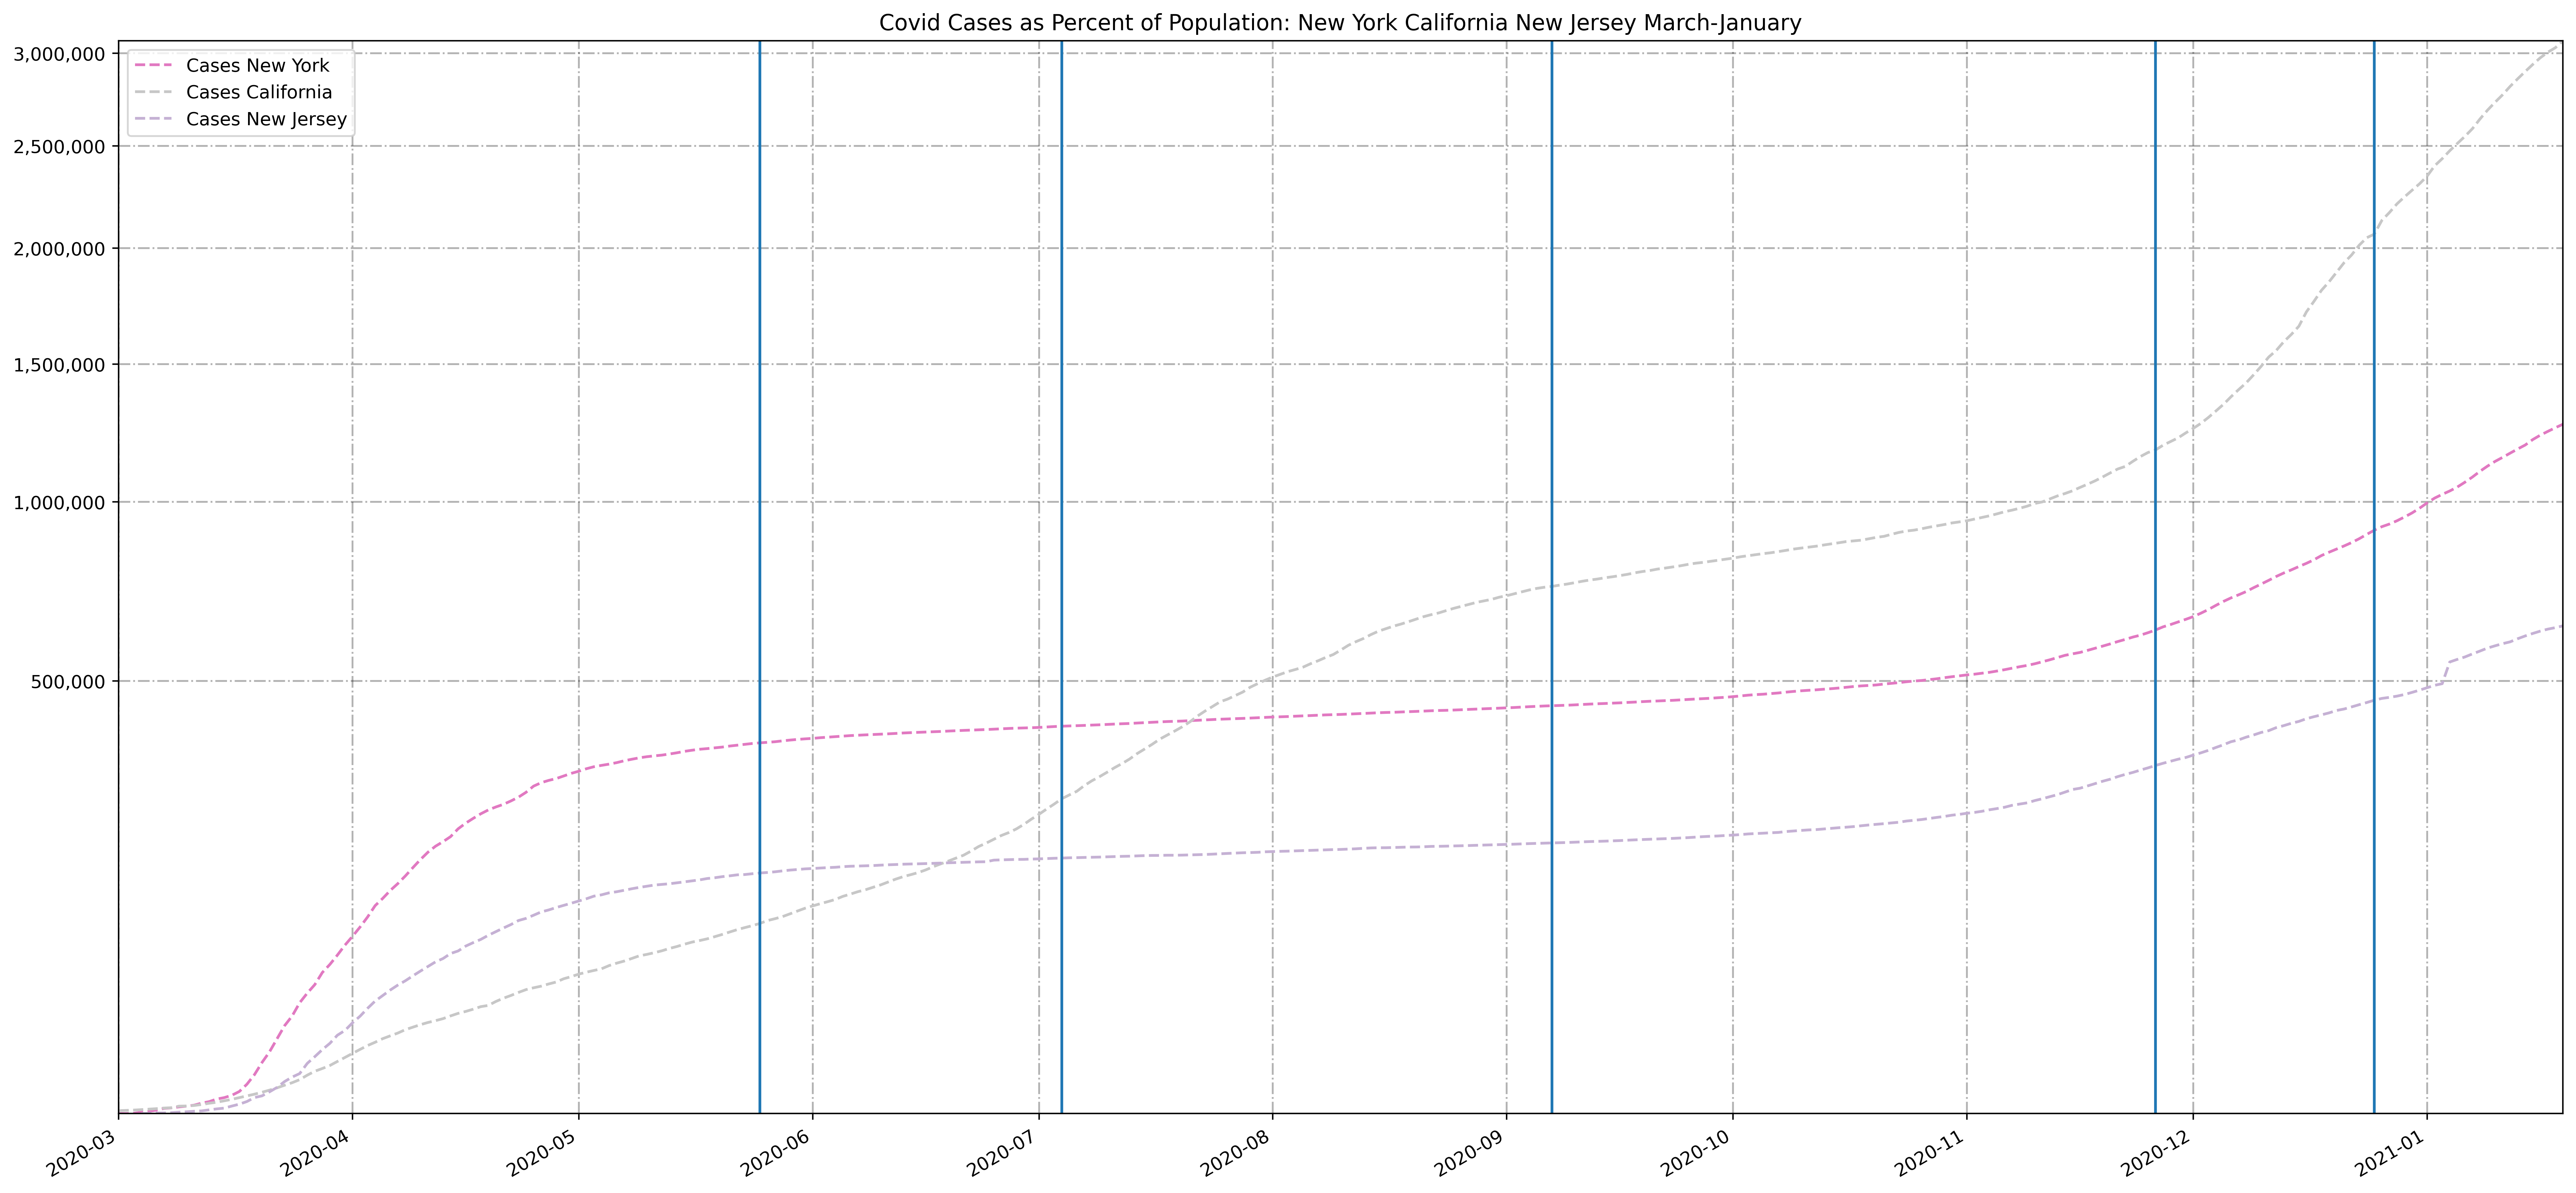

In [262]:
plt_multi = plot_helper_capita(per_capita)